In [80]:
#!/usr/bin/env python
# coding: utf-8

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10,10

from scipy.ndimage.interpolation import zoom
import VGG
import gradcamutils
import innvestigate
import numpy as np
import os
from PIL import Image
import innvestigate

from VGG import *

In [81]:
# use this environment flag to change which GPU to use 
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  # specify which GPU(s) to be used

In [82]:
def createOrRestoreModel(): 
    vggModel = VGG.VGG19((224,224,3),4, False) #set up model architecture

    vggModel.summary()
    vggModel.load_weights("VGG19_COVID19.h5") #load weights

    model = vggModel

    return model 

In [83]:
def readTestImage(img_path): 
    img = Image.open(img_path) #open image you want to visualize "1238_R.png"

    img = np.array(img.resize((224,224), Image.ANTIALIAS))
    imgArr = img.reshape(1,224,224,3)#open image you want to visualize
    imgNormalized = imgArr / 255.
    
    return img, imgArr, imgNormalized

In [86]:
img_path = "images/1312A392-67A3-4EBF-9319-810CF6DA5EF6.jpeg"
img, imgArr, imgNormalized = readTestImage(img_path)

In [87]:
model = createOrRestoreModel() 

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 2)       56        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 2)       38        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 2)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 4)       76        
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 4)       148       
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 4)         0     

In [88]:
def createLRPAnalyzer(model, imgNormalized):
    '''
    All possible names are: ['input', 'random', 'gradient', 'gradient.baseline', 'input_t_gradient', 
    'deconvnet', 'guided_backprop', 'integrated_gradients', 'smoothgrad', 'lrp', 'lrp.z', 'lrp.z_IB', 
    'lrp.epsilon', 'lrp.epsilon_IB', 'lrp.w_square', 'lrp.flat', 'lrp.alpha_beta', 'lrp.alpha_2_beta_1', 
    'lrp.alpha_2_beta_1_IB', 'lrp.alpha_1_beta_0', 'lrp.alpha_1_beta_0_IB', 'lrp.z_plus', 'lrp.z_plus_fast', 
    'lrp.sequential_preset_a', 'lrp.sequential_preset_b', 'lrp.sequential_preset_a_flat', 
    'lrp.sequential_preset_b_flat', 'deep_taylor', 'deep_taylor.bounded', 'deep_lift.wrapper', 
    'pattern.net', 'pattern.attribution']"
    '''

    analyzer = innvestigate.create_analyzer("lrp.sequential_preset_a_flat", model, reverse_keep_tensors=True)
    analysis = analyzer.analyze(imgNormalized)
    
    relScore = analyzer._reversed_tensors
    
    a = analysis
    a /= np.max(np.abs(a))
    
    return a, relScore

In [89]:
gradCAM = gradcamutils.grad_cam(model, imgNormalized, layer_name = 'block5_conv4') #for VGG, here there are parameters to set image width (W) and height (H)
gradCAMPlus = gradcamutils.grad_cam_plus(model, imgNormalized, layer_name = 'block5_conv4')
LRP, relScore = createLRPAnalyzer(model, imgNormalized)

3
3


In [90]:
pred = model.predict(imgNormalized)

class_prob = pred.tolist()
softMaxProb = class_prob[0]

softMaxProb

[-5.733123779296875, 0.10805684328079224, 1.8291599750518799, 2.04530668258667]

In [91]:
def remove_ticks_and_labels(ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.tick_params(axis='both', which='both', length=0)

In [92]:
def decisionVisualization(img, xaiMethod, vizMethod):
    # Add batch axis and preprocess   

    fig = plt.figure(constrained_layout=False,figsize=[6,3])
    gs1 = fig.add_gridspec(nrows=1, ncols=2, left=1, right=1.8)

    fig_ax1 = fig.add_subplot(gs1[0, 0])
    fig_ax2 = fig.add_subplot(gs1[0, 1])

    gs2 = fig.add_gridspec(nrows=1, ncols=1, left=1.92, right=2.6)

    fig_ax3 = fig.add_subplot(gs2[0, 0])

    fig_ax1.imshow(img, cmap ='gray')
    fig_ax1.set_title("Input radiograph")

    remove_ticks_and_labels(fig_ax1)
    
    if vizMethod == 'LRP':
        norm = LRP[0,:,:,0] 

        fig_ax2.imshow(img, cmap ='Reds_r')
        fig_ax2.imshow(norm, vmax = 1, vmin = -1,alpha=0.45, cmap="jet")
        fig_ax2.set_title(str(vizMethod))
        remove_ticks_and_labels(fig_ax2)

        #x_probs = [0.12, 0.30, 0.48, 0.10]
        x_probs = softMaxProb
        
        x_probs = np.asarray(x_probs, dtype=np.float32)
        y_pos = np.array([0, 1, 2, 3])
        y_objects = ('Type-1','Type-2','Type-3','Type-4') #Infection type
        y_labels = ['Normal', 'Bacterial', 'Non-COVID19 Viral', 'COVID-19 Viral']

        fig_ax3.barh(y_pos, x_probs, color='green', align='center', alpha=0.3)
        fig_ax3.set_title("Explanations")
    
        for i, v in enumerate(x_probs):
            fig_ax3.text(v - 0.07, i + 0.1 , '{0:.2f}   {1}'.format(v,y_labels[i]))
    
        fig_ax3.set_yticks(y_pos)
        fig_ax3.set_yticklabels(y_objects)
        fig_ax3.invert_yaxis()  # labels read top-to-bottom
        fig_ax3.set_xticks([0, 0.25, 0.5, 0.75])

        fig.savefig('explanation.png')
        
    if vizMethod == 'CAM':

        fig_ax2.imshow(img, cmap ='gray')
        fig_ax2.imshow(xaiMethod, alpha=0.45, cmap="jet")
        fig_ax2.set_title(str(vizMethod))
        remove_ticks_and_labels(fig_ax2)

        #x_probs = [0.12, 0.30, 0.48, 0.10]
        x_probs = softMaxProb
        x_probs = np.asarray(x_probs, dtype=np.float32)
        y_pos = np.array([0, 1, 2, 3])
        y_objects = ('Type-1','Type-2','Type-3','Type-4') #Infection type
        y_labels = ['Normal', 'Bacterial', 'Non-COVID19 Viral', 'COVID-19 Viral']

        fig_ax3.barh(y_pos, x_probs, color='blue', align='center', alpha=0.3)
        fig_ax3.set_title("Explanations")
    
        for i, v in enumerate(x_probs):
            fig_ax3.text(v - 0.07, i + 0.1 , '{0:.2f}   {1}'.format(v,y_labels[i]))
    
        fig_ax3.set_yticks(y_pos)
        fig_ax3.set_yticklabels(y_objects)
        fig_ax3.invert_yaxis()  # labels read top-to-bottom
        fig_ax3.set_xticks([0, 0.25, 0.5, 0.75])

        fig.savefig('explanation.png')
        
    if vizMethod == 'CAMPlus':

        fig_ax2.imshow(img, cmap ='gray')
        fig_ax2.imshow(xaiMethod, alpha=0.45, cmap="jet")
        fig_ax2.set_title(str(vizMethod))
        remove_ticks_and_labels(fig_ax2)

        #x_probs = [0.12, 0.30, 0.48, 0.10]
        x_probs = softMaxProb
        x_probs = np.asarray(x_probs, dtype=np.float32)
        y_pos = np.array([0, 1, 2, 3])
        y_objects = ('Type-1','Type-2','Type-3','Type-4') #Infection type
        y_labels = ['Normal', 'Bacterial', 'Non-COVID19 Viral', 'COVID-19 Viral']

        fig_ax3.barh(y_pos, x_probs, color='red', align='center', alpha=0.3)
        fig_ax3.set_title("Explanations")
    
        for i, v in enumerate(x_probs):
            fig_ax3.text(v - 0.07, i + 0.1 , '{0:.2f}   {1}'.format(v,y_labels[i]))
    
        fig_ax3.set_yticks(y_pos)
        fig_ax3.set_yticklabels(y_objects)
        fig_ax3.invert_yaxis()  # labels read top-to-bottom
        fig_ax3.set_xticks([0, 0.25, 0.5, 0.75])

        fig.savefig('explanation.png')

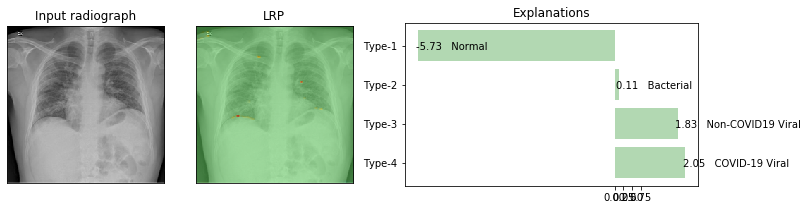

In [93]:
decisionVisualization(img, xaiMethod=LRP, vizMethod='LRP')

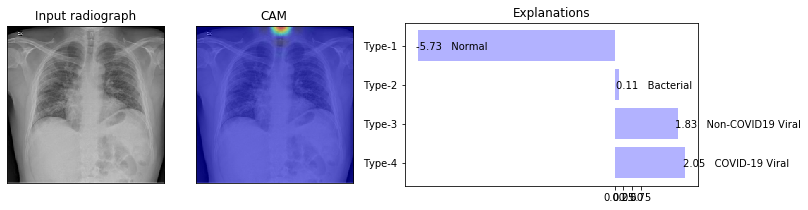

In [94]:
decisionVisualization(img, xaiMethod=gradCAM, vizMethod='CAM')

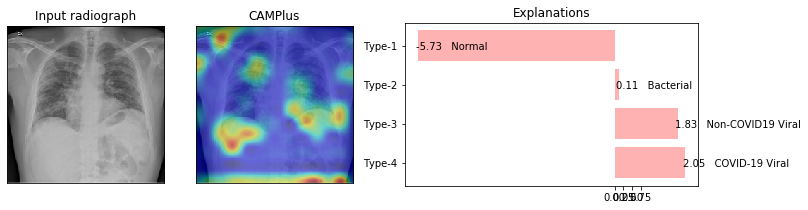

In [95]:
decisionVisualization(img, xaiMethod=gradCAMPlus, vizMethod='CAMPlus')